In [88]:
DIR_PATH = '/Users/anton.andreytsev/Desktop/NER/'
os.chdir(DIR_PATH)

In [89]:
import os 
import sys
import re
import json
import time 
from tqdm import tqdm_notebook
import copy
import pickle
import tqdm
import re
import itertools
import warnings
warnings.filterwarnings('ignore')

In [90]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import gensim
import pymorphy2
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torchtext
from torchtext.data import Field
import gensim
import nltk

In [91]:
# Загружаем необходимый предобработчик (он понадобится для приведения текстов к виду, который использовался для обучения)
from data_preparation import get_preprocessor
# Модуль для записи списка со словарями (выходы парсера) на текстах
from parse_file import parse_file
# Модуль для создания датафрейма для обучения из списка словарей - выхода парсера (результат работы parse_file.py)
from parser_output_to_learning_df import prepate_texts_and_biotags

In [92]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

Пример сборки данных для обучения из консоли:

1) Переходим в папку, где лежат все данные (cd \Users\anton.andreytsev\Desktop\NER)

2) python parse_file.py -fp=<<Путь до файла с сырыми текстами>> -w2s=<<Путь куда сохранить .json с результирующим списком>> --n_lines=50 

После шага 2 получаем файл со списком словарей.

3) python parser_output_to_learning_df.py -fp=\Users\anton.andreytsev\Desktop\NER\health_mail_parsed.json -w2s=.\all_data.csv

Дальше файл all_data.csv нужно разбить на train_df.csv, test_df.csv и val_df.csv

---
### Dataloader preparation
---

Решается задача NER. Над каждым словом нужно поставить тег - один из симптомов или же тег <<о>> - отсутствие тега.

Основные данные для работы уже подготовлены, это тексты train_df, val_df и test_df. Первые 2 нужны для обучения модели, последний - для оценки качества работы модели. Тексты уже лемматизированы. Данные - распарсенные тексты health.mail.ru, и данные медицинских карт, прогнанные через парсер.

Датафреймы имеют такой вид:

Инициализация преобразователей для torchtext

In [7]:
my_tokenizer = lambda x: x.split(' ')
TEXT = Field(sequential=True, tokenize=my_tokenizer, lower=True)
LABEL = Field(sequential=True, tokenize=my_tokenizer, lower=True, unk_token=None)

In [59]:
df_tr = pd.read_csv(os.path.join(DIR_PATH, 'train_df.csv'))
df_val = pd.read_csv(os.path.join(DIR_PATH, 'val_df.csv'))
N_TRAIN_BATCHES = len(df_tr) # дальше поделим на BATCH_SIZE
N_VAL_BATCHES = len(df_val)
del df_tr, df_val

In [27]:
%%time
# Составление из сохранённых выше файлов (train_df.csv, test_df.csv и val_df.csv) словаря встречаемости слов для дальнейшего составление батчей 
from torchtext.data import TabularDataset
trn_datafields = [("texts", TEXT), ("tags", LABEL)]
trn = TabularDataset(
           path=os.path.join(DIR_PATH, 'train_df.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=trn_datafields)

val_datafields = [("texts", TEXT), ("tags", LABEL)]
val = TabularDataset(
           path=os.path.join(DIR_PATH, 'val_df.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=val_datafields)
 
tst_datafields = [("texts", TEXT), ('tags', LABEL)]
tst = TabularDataset(
           path=os.path.join(DIR_PATH, 'test_df.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=tst_datafields)


Wall time: 32.1 s


In [28]:
# Составление словаря
TEXT.build_vocab(trn, max_size=50000, specials_first=True)
LABEL.build_vocab(trn, specials_first=False)
words_id_dict = dict(TEXT.vocab.stoi)
tags_id_dict = dict(LABEL.vocab.stoi)
json.dump(words_id_dict, open(os.path.join(DIR_PATH, 'words_id_dict.json'), mode='w', encoding='utf-8'), indent=2, ensure_ascii=False)
json.dump(tags_id_dict, open(os.path.join(DIR_PATH, 'tags_id_dict.json'), mode='w', encoding='utf-8'), indent=2, ensure_ascii=False)

In [29]:
# Составление батчей 
from torchtext.data import Iterator, BucketIterator
BATCH_SIZE = 100
N_TRAIN_BATCHES /= BATCH_SIZE 
N_VAL_BATCHES /= BATCH_SIZE
train_cards_iter = BucketIterator(trn, batch_size=BATCH_SIZE, device=torch.device('cuda:0'), sort_key=lambda x: len(x.texts), 
                                sort_within_batch=True, repeat=False)
test_cards_iter = BucketIterator(tst, batch_size=BATCH_SIZE, device=torch.device('cuda:0'), sort_key=lambda x: len(x.texts), 
                                sort_within_batch=True, repeat=False)
val_cards_iter = BucketIterator(val, batch_size=BATCH_SIZE, device=torch.device('cuda:0'), sort_key=lambda x: len(x.texts), 
                                sort_within_batch=True, repeat=False)

class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y
    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

train_cards_dl = BatchWrapper(train_cards_iter, 'texts', ['tags'])
test_cards_dl = BatchWrapper(test_cards_iter, 'texts', ['tags'])
val_cards_dl = BatchWrapper(val_cards_iter, 'texts', ['tags'])

In [291]:
x, y = next(val_cards_dl.__iter__()) # Пример батчей X, y
y = y.squeeze()

---
### Model and train
---

In [30]:
#  Нейросетка для NER
class LSTM_TAGGER(nn.Module):
    def __init__(self, device, vocab_size, hidd_dim, num_layers, n_classes, embedding_dim=100, 
                 bidirectional=True, dropout_prob=0.2, lstm_dropout=0.3):
        super(LSTM_TAGGER, self).__init__()
        self.device = device
        self.num_lay = num_layers
        self.hidd_dim = hidd_dim
        self.number_of_dir = 2 if bidirectional else 1
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidd_dim, num_layers=num_layers, bidirectional=bidirectional, 
                          dropout=lstm_dropout)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.dense = nn.Linear(in_features=hidd_dim*self.number_of_dir, out_features=n_classes)
        self.hidden_state = None
        
    def init_hidden(self, x=None):
        if x is None:
            return (torch.zeros((self.num_lay*self.number_of_dir, self.batch_size, self.hidd_dim)).to(device=self.device), 
                    torch.zeros((self.num_lay*self.number_of_dir, self.batch_size, self.hidd_dim)).to(device=self.device))
        else:
            return (torch.zeros((self.num_lay*self.number_of_dir, x.shape[1], self.hidd_dim)).to(device=x.device.type), 
                    torch.zeros((self.num_lay*self.number_of_dir, x.shape[1], self.hidd_dim)).to(device=x.device.type))
    
    def forward(self, x):
        # x  - (Seq_len, Batch_size)
        x_emb = self.dropout(self.embed(x))
        x_emb = pack_padded_sequence(x_emb, lengths=[sum(i.cpu() != words_id_dict['<pad>']).item() for i in x.t()])
        out_packed, self.hidden_state = self.rnn(x_emb, self.hidden_state)
        out_unpacked = pad_packed_sequence(out_packed)[0]
        return self.dense(out_unpacked)

Сохраним архитектуру сетки в .py файл для дальнейшего вызова

In [76]:
# %%writefile /Users/anton.andreytsev/Desktop/NER/model_architecture.py

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# # Не забыть изменить PAD_TOKEN!!!
# PAD_TOKEN = 1

# class LSTM_TAGGER(nn.Module):
#     def __init__(self, device, vocab_size, hidd_dim, num_layers, n_classes, embedding_dim=100, 
#                  bidirectional=True, dropout_prob=0.2, lstm_dropout=0.3):
#         super(LSTM_TAGGER, self).__init__()
#         self.device = device
#         self.num_lay = num_layers
#         self.hidd_dim = hidd_dim
#         self.number_of_dir = 2 if bidirectional else 1
#         self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
#         self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidd_dim, num_layers=num_layers, bidirectional=bidirectional, 
#                           dropout=lstm_dropout)
#         self.dropout = nn.Dropout(p=dropout_prob)
#         self.dense = nn.Linear(in_features=hidd_dim*self.number_of_dir, out_features=n_classes)
#         self.hidden_state = None
        
#     def init_hidden(self, x=None):
#         if x is None:
#             return (torch.zeros((self.num_lay*self.number_of_dir, self.batch_size, self.hidd_dim)).to(device=self.device), 
#                     torch.zeros((self.num_lay*self.number_of_dir, self.batch_size, self.hidd_dim)).to(device=self.device))
#         else:
#             return (torch.zeros((self.num_lay*self.number_of_dir, x.shape[1], self.hidd_dim)).to(device=x.device.type), 
#                     torch.zeros((self.num_lay*self.number_of_dir, x.shape[1], self.hidd_dim)).to(device=x.device.type))
    
#     def forward(self, x):
#         # x  - (Seq_len, Batch_size)
#         x_emb = self.dropout(self.embed(x))
#         x_emb = pack_padded_sequence(x_emb, lengths=[sum(i.cpu() != PAD_TOKEN).item() for i in x.t()])
#         out_packed, self.hidden_state = self.rnn(x_emb, self.hidden_state)
#         out_unpacked = pad_packed_sequence(out_packed)[0]
#         return self.dense(out_unpacked)

Overwriting /Users/anton.andreytsev/Desktop/NER/model_architecture.py


In [31]:
VOCAB_SIZE = 50002 #len(words_id_dict)
PAD_IDX = tags_id_dict['<pad>']
DEVICE = 'cuda'

In [32]:
# Инициализация сети
# Больше двух слоёв LSTM не пробовал - долго обучается, hidden_size > 300 в память не влезает. С такими параметрами вроде норм
model_lstm = LSTM_TAGGER(num_layers=2, hidd_dim=200, n_classes=len(tags_id_dict)-1, embedding_dim=300, vocab_size=VOCAB_SIZE,
                          bidirectional=True, device='cuda')
criterion = nn.CrossEntropyLoss(ignore_index=tags_id_dict['<pad>'], reduction='mean')
opt = optim.Adam(model_lstm.parameters(), lr=1e-4)
reduce_plato = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.01)

In [33]:
# Обучение сети
EPOCHS = 100
model_lstm.to(DEVICE) # перевод сети на gpu
criterion.to(DEVICE)
train_loss_epochs = []
test_loss_epochs = []
for epoch in tqdm_notebook(range(1, EPOCHS)):
    model_lstm.to(DEVICE)
    model_lstm.train()
    train_loss = 0
    st = time.perf_counter()
    for x_, y_ in train_cards_dl: 
        opt.zero_grad()
        y_ = y_.squeeze(1).long().to(DEVICE)
        model_lstm.hidden_state = model_lstm.init_hidden(x_)
        y_pred = model_lstm(x_)
        lo = 0
        for word_number in range(y_.shape[0]):
            lo += criterion(y_pred[word_number], y_[word_number])
        lo.backward()
        train_loss += lo.cpu().item()/N_TRAIN_BATCHES
        opt.step()
    train_loss_epochs.append(train_loss)
    
    with torch.no_grad():
        model_lstm.eval()
        test_loss = 0
        for x_test, y_test in val_cards_dl:
            y_test = y_test.squeeze(1).long().to(DEVICE)
            model_lstm.hidden_state = model_lstm.init_hidden(x_test)
            y_pred = model_lstm(x_test)
            los = 0
            for word_number in range(y_test.shape[0]):
                los += criterion(y_pred[word_number], y_test[word_number])
            test_loss += los.cpu().item()/N_VAL_BATCHES
        test_loss_epochs.append(test_loss) 
        reduce_plato.step(test_loss)
        
#     Сохранение результатов
    json.dump(train_loss_epochs, open(os.path.join(DIR_PATH, 'train_loss.json'), mode='w', encoding='utf-8'), ensure_ascii=False, indent=2)
    json.dump(test_loss_epochs, open(os.path.join(DIR_PATH, 'val_loss.json'), mode='w', encoding='utf-8'), ensure_ascii=False, indent=2)

    
    torch.save(model_lstm.cpu().state_dict(), os.path.join(DIR_PATH, 'net_params_epoch_{}'.format(epoch)))
    
    print('Epoch: {} Train loss: {:.4f} Test loss: {:.4f} Time: {:.2f}'.format(epoch, train_loss_epochs[-1], test_loss_epochs[-1], 
                                                                               time.perf_counter() - st))

Epoch: 1 Train loss: 32.7105 Test loss: 11.8372 Time: 425.57
Epoch: 2 Train loss: 9.3469 Test loss: 6.8283 Time: 417.52
Epoch: 3 Train loss: 5.9917 Test loss: 4.5990 Time: 429.83
Epoch: 4 Train loss: 4.2887 Test loss: 3.3487 Time: 442.40
Epoch: 5 Train loss: 3.2497 Test loss: 2.5904 Time: 441.52
Epoch: 6 Train loss: 2.5869 Test loss: 2.1347 Time: 441.23
Epoch: 7 Train loss: 2.1365 Test loss: 1.7978 Time: 442.90
Epoch: 8 Train loss: 1.8101 Test loss: 1.5180 Time: 445.94
Epoch: 9 Train loss: 1.5716 Test loss: 1.3435 Time: 444.73
Epoch: 10 Train loss: 1.3810 Test loss: 1.2133 Time: 444.70
Epoch: 11 Train loss: 1.2313 Test loss: 1.1367 Time: 445.40
Epoch: 12 Train loss: 1.1039 Test loss: 1.0169 Time: 443.20
Epoch: 13 Train loss: 1.0080 Test loss: 0.9650 Time: 442.13
Epoch: 14 Train loss: 0.9110 Test loss: 0.9063 Time: 444.63
Epoch: 15 Train loss: 0.8402 Test loss: 0.8685 Time: 445.85
Epoch: 16 Train loss: 0.7718 Test loss: 0.7986 Time: 443.64
Epoch: 17 Train loss: 0.7153 Test loss: 0.8300 

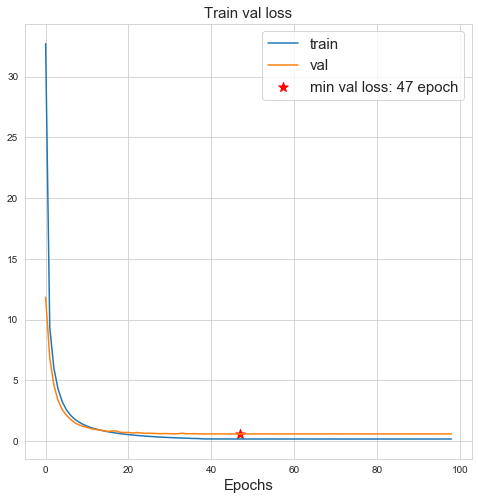

In [40]:
plt.figure(figsize=(8,8))
plt.plot(train_loss_epochs, label=u'train')
plt.plot(test_loss_epochs, label=u'val')
plt.title(u'Train val loss', fontsize=15)
plt.xlabel(u'Epochs', fontsize=15)
plt.scatter(np.argmin(test_loss_epochs), test_loss_epochs[np.argmin(test_loss_epochs)], marker='*', s=100, color='red', 
            label=u'min val loss: {} epoch'.format(np.argmin(test_loss_epochs)))
plt.legend(fontsize=15);

In [ ]:
## Записываем параметры сети в словарь и сохраняем его
# used_parameters_dict = {'num_layers': 2, 'hidd_dim': 200, 'n_classes': len(tags_id_dict)-1, 'embedding_dim': 300, 'vocab_size': VOCAB_SIZE,
#                           "bidirectional": True, "device": 'cpu'}
# json.dump(used_parameters_dict, open(os.path.join(DIR_PATH, 'model_parameters_used.json'), mode='w', encoding='utf-8'), indent=2, 
#          ensure_ascii=False)

Загружаем модель для тестирования

In [9]:
from model_architecture import LSTM_TAGGER
# Загружаем параметры модели
used_parameters_dict = json.load(open(os.path.join(DIR_PATH, 'model_parameters_used.json'), mode='r', encoding='utf-8'))
# Инициализируем модель
test_model = LSTM_TAGGER(**used_parameters_dict)
# Загружаем обученные веса
test_model.load_state_dict(torch.load(os.path.join(DIR_PATH, 'net_params_epoch_99')))
# Переводим на ЦПУ и в состоение <<тестирование>> (чтобы не считался dropout, batchnorm, ...)
test_model.cpu()
test_model.eval()
# Загружаем словари слово - id, тег - id
words_id_dict = json.load(open(os.path.join(DIR_PATH, 'words_id_dict.json'), mode='r', encoding='utf-8'))
tags_id_dict = json.load(open(os.path.join(DIR_PATH, 'tags_id_dict.json'), mode='r', encoding='utf-8'))

Тестирование качества модели на отложенной выборке

In [10]:
from sklearn.metrics import f1_score
test_model.cpu()
test_model.eval()
df_te = pd.read_csv(os.path.join(DIR_PATH, 'test_df.csv'))
true_tags = []
predicted_tags = []
random_subindexes = np.random.choice(np.arange(len(df_te)), size=28000, replace=False)
for text, tags in tqdm_notebook(df_te.values[random_subindexes]):
    true_tags.extend([tags_id_dict.get(i, -1) for i in tags.split()])
    sentence_vec = torch.LongTensor([words_id_dict.get(word, words_id_dict['<unk>']) for word in text.split()]).reshape(-1, 1)
    with torch.no_grad():
        test_model.hidden_state = test_model.init_hidden(sentence_vec)
        y_pred = np.argmax(F.log_softmax(test_model(sentence_vec), dim=2).squeeze(1).detach().numpy(), axis=1)
        predicted_tags.extend(y_pred)
    if len([tags_id_dict.get(i, -1) for i in tags.split()]) != len(y_pred):
        print('длины не равны!')
        break
print('F мера без учёта тега <o>:', f1_score(y_true=true_tags, y_pred=predicted_tags, average='micro', 
                                             labels=list(tags_id_dict.values())[1:]))


F мера без учёта тега <o>: 0.9849000359767693


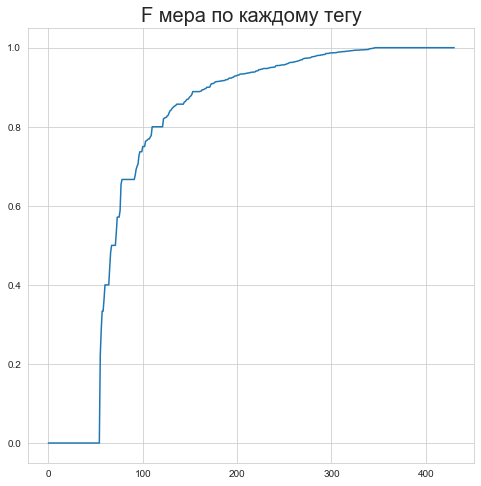

In [23]:
plt.title('F мера по каждому тегу', fontsize=20);
separate_f_score = f1_score(y_true=true_tags, y_pred=predicted_tags, average=None)
plt.plot(np.sort(separate_f_score));

Предсказание тегов на одном тексте

In [36]:
id_tags_dict = {x: y for y, x in tags_id_dict.items()}

In [47]:
init_text = 'Последние несколько дней держится высокая температура'
init_text = 'Насморк длится непереставая!'
init_text = 'Болит живот'
init_text = 'Мучает боль в спине'
text = text_preprocess(init_text, lemmatized=True)
test_model.cpu()
test_model.eval()
with torch.no_grad():
    sentence_vec = torch.LongTensor([words_id_dict.get(word, words_id_dict['<unk>']) for word in text]).reshape(-1, 1)
    with torch.no_grad():
        test_model.hidden_state = test_model.init_hidden(sentence_vec)
        y_pred = np.argmax(F.log_softmax(test_model(sentence_vec), dim=2).squeeze(1).detach().numpy(), axis=1)
print(init_text)
print()
[(word, id_tags_dict.get(id_, '<unk>')) for word, id_ in zip(text, y_pred)]

Мучает боль в спине



[('мучить', 'o'),
 ('боль', 'b-боль_в_спине'),
 ('в', 'i-боль_в_спине'),
 ('спина', 'i-боль_в_спине')]